In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [5]:
path = Path('data/imgs/train')
path.ls()

[PosixPath('data/imgs/train/c2'),
 PosixPath('data/imgs/train/c6'),
 PosixPath('data/imgs/train/export.pkl'),
 PosixPath('data/imgs/train/c4'),
 PosixPath('data/imgs/train/c0'),
 PosixPath('data/imgs/train/c5'),
 PosixPath('data/imgs/train/c3'),
 PosixPath('data/imgs/train/c1'),
 PosixPath('data/imgs/train/models'),
 PosixPath('data/imgs/train/c8'),
 PosixPath('data/imgs/train/c7'),
 PosixPath('data/imgs/train/c9')]

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', test='../test', valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

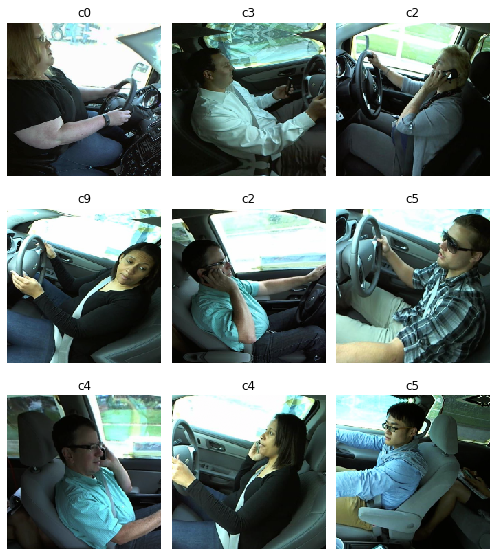

In [7]:
data.show_batch(rows=3, figsize=(7,8))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], 10, 17940, 4484)

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [10]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.710698,0.260042,0.082070,04:27
1,0.315018,0.114517,0.032114,02:50
2,0.190406,0.057856,0.016280,02:46
3,0.131342,0.039971,0.011374,02:46
4,0.093476,0.034831,0.010036,02:46


In [11]:
learn.save('stage-1')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


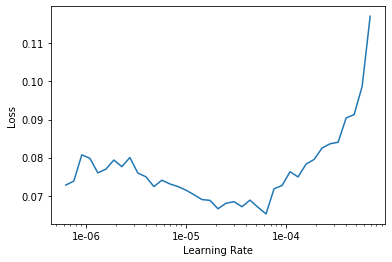

In [14]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, max_lr=slice(3e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.095234,0.039822,0.011597,02:46
1,0.105175,0.062419,0.014496,02:46
2,0.079505,0.040175,0.010259,02:46
3,0.072175,0.061623,0.016280,02:46
4,0.048380,0.027750,0.008252,02:46
5,0.034642,0.020533,0.005352,02:45
6,0.022706,0.011273,0.003122,02:47
7,0.008547,0.010705,0.002230,02:46
8,0.003924,0.006879,0.001561,02:46
9,0.004102,0.007156,0.001784,02:46


In [17]:
learn.save('stage-2')

In [18]:
learn.export()

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

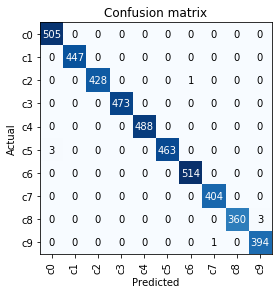

In [20]:
interp.plot_confusion_matrix()

In [21]:
interp.most_confused()

[('c5', 'c0', 3), ('c8', 'c9', 3), ('c2', 'c6', 1), ('c9', 'c7', 1)]

## Submission

In [14]:
# item_list = ItemList.from_folder('data/imgs/test')
# learn = load_learner(path, test=item_list)
# preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [19]:
submissions = pd.read_csv('data/sample_submission.csv')
id_list = list(submissions.img)
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [24]:
pred_list = list(preds)
pred_dict = dict((key, value.item()) for (key, value) in zip(learn.data.test_ds.items, pred_list))
pred_dict

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
pred_ordered = [pred_dict[Path('data/imgs/test/' + id)] for id in id_list]
submissions = pd.DataFrame({'id':id_list,'label':pred_ordered})
submissions.to_csv("submission.csv", index = False)